# Predicting results

## Imports

In [2]:
import mysql.connector as sql
import pandas as pd
import numpy as np
from datetime import date, timedelta

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import display, HTML
from tqdm import tqdm

## Definitions

In [3]:
from_year=2016
to_year=2018
streak_days_long=100
streak_days_short=20

In [4]:
def get_prev_matches_numbers(date_start, date_end, team_id, df):
    dfteam_previous = df[((df["team_home_id"]==team_id) | (df["team_away_id"]==team_id)) & (df["kickoff_time"]<date_end) & (df["kickoff_time"]>date_start)].copy()
    if len(dfteam_previous) == 0:
        win_rate = 0.
        score_diff_avg = 0.
    else:
        dfteam_previous["score_team"] = dfteam_previous.apply(lambda x: x["score_home"] if x["team_home_id"]==team_id else x["score_away"], axis=1)
        dfteam_previous["score_oponent"] = dfteam_previous.apply(lambda x: x["score_away"] if x["team_home_id"]==team_id else x["score_home"], axis=1)
        dfteam_previous["won"] = dfteam_previous["score_team"] > dfteam_previous["score_oponent"]
        dfteam_previous["score_diff"] = dfteam_previous["score_team"] - dfteam_previous["score_oponent"]
        win_rate = float(dfteam_previous["won"].sum()) / len(dfteam_previous)
        score_diff_avg = dfteam_previous["score_diff"].mean()
    return win_rate, score_diff_avg

In [5]:
def calculate_variables_last_X_train(df_games, last_X_days):
    # for each game add results of last ones
    win_rate_home_list = []
    win_rate_away_list = []
    score_diff_avg_home_list = []
    score_diff_avg_away_list = []
    for i, row in tqdm(df_games.iterrows()):
        date_end = row["kickoff_time"]
        date_start = date_end - timedelta(days=last_X_days)
        # For the home team
        team_id = row["team_home_id"]
        # print("Home team:", team_id)
        win_rate_home, score_diff_avg_home = get_prev_matches_numbers(date_start, date_end, team_id, df_games)
        win_rate_home_list += [win_rate_home]
        score_diff_avg_home_list += [score_diff_avg_home]
        # For the away team
        team_id = row["team_away_id"]
        # print("Away team:", team_id)
        win_rate_away, score_diff_avg_away = get_prev_matches_numbers(date_start, date_end, team_id, df_games)
        win_rate_away_list += [win_rate_away]
        score_diff_avg_away_list += [score_diff_avg_away]

    # add historical to df
    df_games["win_rate_home_last"+str(last_X_days)] = win_rate_home_list
    df_games["score_diff_avg_home_last"+str(last_X_days)] = score_diff_avg_home_list
    df_games["win_rate_away_last"+str(last_X_days)] = win_rate_away_list
    df_games["score_diff_avg_away_last"+str(last_X_days)] = score_diff_avg_away_list

    return df_games

In [6]:
def calculate_variables_last_X_predict(df_predict, df_games, last_X_days):
    # for each game add results of last ones
    win_rate_home_list = []
    win_rate_away_list = []
    score_diff_avg_home_list = []
    score_diff_avg_away_list = []
    for i, row in tqdm(df_predict.iterrows()):
        date_end = row["kickoff_time"]
        date_start = date_end - timedelta(days=last_X_days)
        # For the home team
        team_id = row["team_home_id"]
        # print("Home team:", team_id)
        win_rate_home, score_diff_avg_home = get_prev_matches_numbers(date_start, date_end, team_id, df_games)
        win_rate_home_list += [win_rate_home]
        score_diff_avg_home_list += [score_diff_avg_home]
        # For the away team
        team_id = row["team_away_id"]
        # print("Away team:", team_id)
        win_rate_away, score_diff_avg_away = get_prev_matches_numbers(date_start, date_end, team_id, df_games)
        win_rate_away_list += [win_rate_away]
        score_diff_avg_away_list += [score_diff_avg_away]

    # add historical to df
    df_predict["win_rate_home_last" + str(last_X_days)] = win_rate_home_list
    df_predict["score_diff_avg_home_last" + str(last_X_days)] = score_diff_avg_home_list
    df_predict["win_rate_away_last" + str(last_X_days)] = win_rate_away_list
    df_predict["score_diff_avg_away_last" + str(last_X_days)] = score_diff_avg_away_list

    return df_predict

## Loading data from db

In [7]:
#DB connection
db_connection = sql.connect(host='localhost', port=3306, database='acb', user='root', password='root')
df_games = pd.read_sql('SELECT * FROM game where game.season >= {}'.format(from_year), con=db_connection)

#print(df_games.shape)
#print(df_games.columns)
#df_games.head()

## Correlations

In [8]:
#correlation matrix
#corrmat = df_games.corr()
#f, ax = plt.subplots(figsize=(20,18))
#sns.heatmap(corrmat, square=True, cmap=sns.diverging_palette(240, 10, as_cmap=True))
#plt.show()

In [9]:
#cols_aux = [c for c in df_games.columns if (c.startswith("score") and not c.endswith("extra"))]
#print(cols_aux)
#sns.set(style="ticks", color_codes=True)
#sns.pairplot(df_games[cols_aux])
#plt.show()

## Preprocessing

In [10]:
# cols to keep
cols_to_keep = ['team_home_id', 'team_away_id', 'season', 'journey', 'kickoff_time',
                'score_home', 'score_away', 'referee_1']
cols_to_del = [c for c in df_games.columns if c not in cols_to_keep]
df_games.drop(cols_to_del, axis=1, inplace=True)

# check if nulls
#print("Number of nulls in df:", df_games.isnull().sum().max())

# checking amount of times a home team won
#win_home = df_games["score_away"] < df_games["score_home"]
#print("Home Team Win percentage: {0:.1f}%".format(100 * win_home.values.sum() / len(win_home)))

# create score difference feature
df_games["score_difference"] = df_games["score_home"] - df_games["score_away"]
#print("Mean of score difference:", df_games["score_difference"].mean())

df_games=calculate_variables_last_X_train(df_games, streak_days_long)
df_games=calculate_variables_last_X_train(df_games, streak_days_short)
df_games.head()

802it [00:09, 88.70it/s]
802it [00:08, 94.55it/s] 


,team_home_id,team_away_id,season,journey,score_home,score_away,kickoff_time,referee_1,score_difference,win_rate_home_last100,score_diff_avg_home_last100,win_rate_away_last100,score_diff_avg_away_last100,win_rate_home_last20,score_diff_avg_home_last20,win_rate_away_last20,score_diff_avg_away_last20
0,1,8,2018,1,88,73,2018-09-30 19:15:00,Jiménez Trujillo,15,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,18,1,2018,2,70,88,2018-10-05 20:45:00,Antonio Conde,-18,0.000000,-13.000000,1.000000,15.000000,0.0,-13.0,1.0,15.0
2,3,2,2018,12,78,73,2018-12-16 19:30:00,Carlos Peruga,5,0.727273,6.000000,0.909091,13.181818,0.0,-7.0,1.0,4.0
3,17,9,2018,12,83,68,2018-12-16 19:30:00,M.A. Pérez Pérez,15,0.272727,-4.454545,0.545455,-3.090909,0.0,-24.0,1.0,7.0
4,4,16,2018,12,76,87,2018-12-15 20:30:00,Daniel Hierrezuelo,-11,0.454545,-3.636364,0.181818,-10.545455,0.0,-19.0,0.0,-14.0


In [11]:
df_games_inverse = df_games.copy()
for c in df_games_inverse.columns:
    if "home" in c:
        df_games_inverse[c.replace("home", "away")] = df_games[c]
    if "away" in c:
        df_games_inverse[c.replace("away", "home")] = df_games[c]
df_games_inverse["score_difference"] = -df_games["score_difference"]        
df_games_inverse.head()

,team_home_id,team_away_id,season,journey,score_home,score_away,kickoff_time,referee_1,score_difference,win_rate_home_last100,score_diff_avg_home_last100,win_rate_away_last100,score_diff_avg_away_last100,win_rate_home_last20,score_diff_avg_home_last20,win_rate_away_last20,score_diff_avg_away_last20
0,8,1,2018,1,73,88,2018-09-30 19:15:00,Jiménez Trujillo,-15,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1,18,2018,2,88,70,2018-10-05 20:45:00,Antonio Conde,18,1.000000,15.000000,0.000000,-13.000000,1.0,15.0,0.0,-13.0
2,2,3,2018,12,73,78,2018-12-16 19:30:00,Carlos Peruga,-5,0.909091,13.181818,0.727273,6.000000,1.0,4.0,0.0,-7.0
3,9,17,2018,12,68,83,2018-12-16 19:30:00,M.A. Pérez Pérez,-15,0.545455,-3.090909,0.272727,-4.454545,1.0,7.0,0.0,-24.0
4,16,4,2018,12,87,76,2018-12-15 20:30:00,Daniel Hierrezuelo,11,0.181818,-10.545455,0.454545,-3.636364,0.0,-14.0,0.0,-19.0


## Regression

Rows for training: 1244
Rows for test: 360
Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')


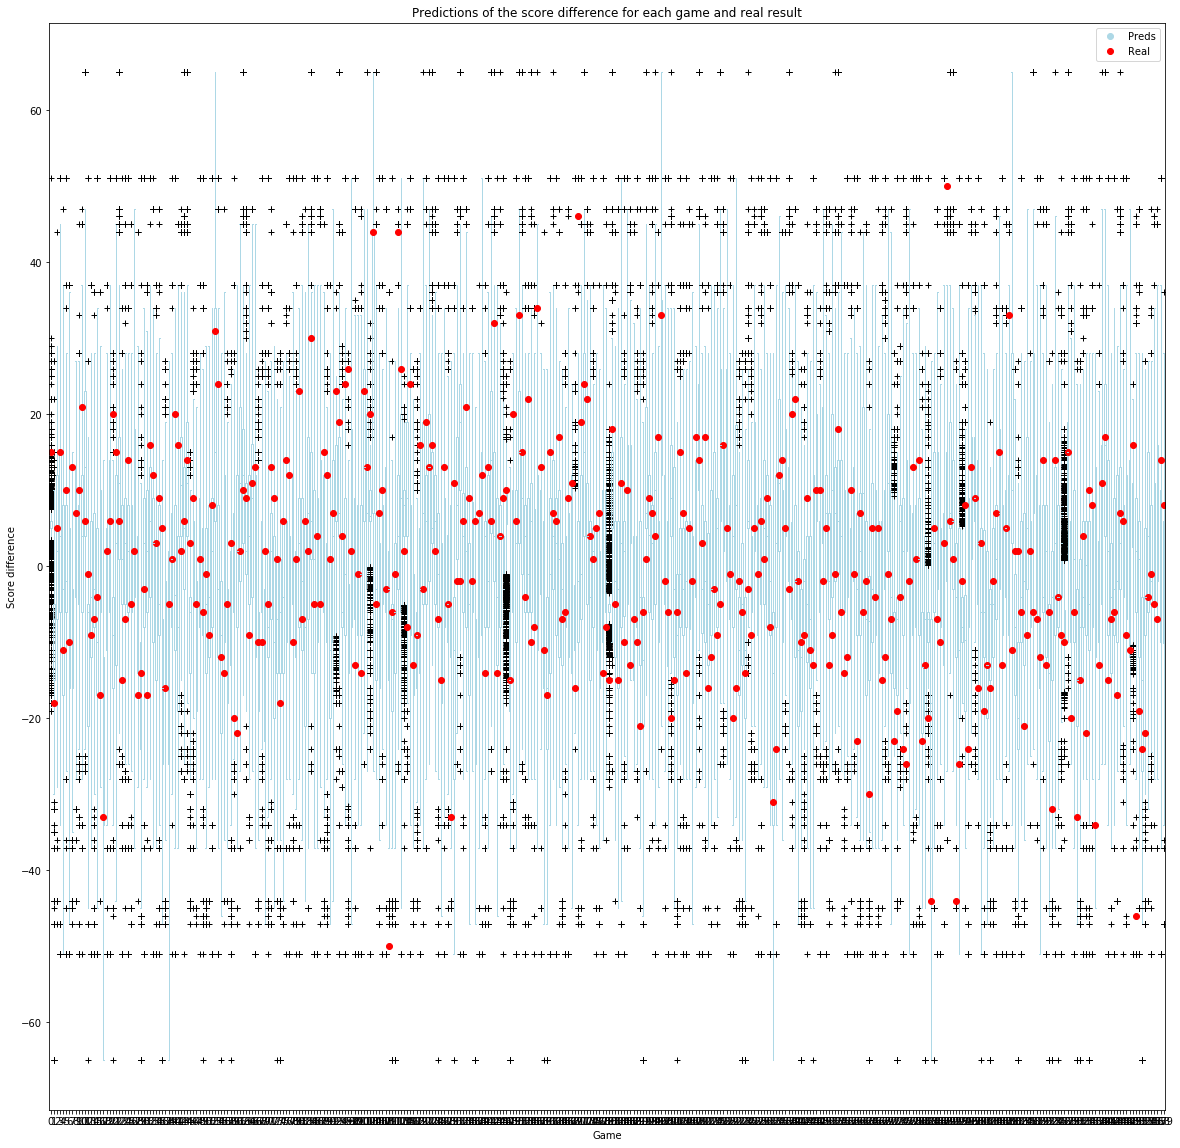

Percentage of the times the mean was positive: 0.5
Percentage of the times the median was positive: 0.5027777777777778
Percentage of the times the score was in the given interval: 96.11111111111111%
Mean absolute error: 11.270411412554799 points
Percentage of the times the winner was correct: 0.6222222222222222%


In [12]:
df_final = pd.concat([df_games, df_games_inverse], ignore_index = True)
#df_final = df_games.copy()
df_final.drop(["score_home", "score_away", "journey", "kickoff_time", "referee_1"], axis=1, inplace=True)
#df_final = df_final[["win_rate_home", "score_diff_avg_home", "win_rate_away", "score_diff_avg_away", "season", "score_difference"]]

# Years for train // Years for test (generally 2016-2017 and 2018)
train = df_final[df_final["season"]<to_year]
test = df_final[df_final["season"]>=to_year]

print("Rows for training:", len(train))
print("Rows for test:", len(test))

X_train = train.drop(['score_difference', "season"], axis=1)
y_train = train['score_difference']
X_test = test.drop(['score_difference', "season"], axis=1)
y_test = test['score_difference'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Train algorithm
print(X_train.columns)
model = RandomForestRegressor(n_estimators=10000, random_state=0, max_depth=20, n_jobs=-1)
model.fit(X_train, y_train)

#print(model.feature_importances_)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = e.predict(X_test)
df_preds_estimators = pd.DataFrame(data=preds_estimators)

# Plotting the intervals and the real value
axes = df_preds_estimators.transpose().plot.box(figsize=(20, 20), positions=range(0,len(X_test)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(y_test, color='red', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each game and real result")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' ')], ['Preds', 'Real'])
plt.show()

# Some conclusions about the intervals
df_preds_estimators["Upper"] = df_preds_estimators.apply(
    lambda x: np.percentile(x, 75) + 1.5 * (np.percentile(x, 75) - np.percentile(x, 25)), axis=1)
df_preds_estimators["Lower"] = df_preds_estimators.apply(
    lambda x: np.percentile(x, 25) - 1.5 * (np.percentile(x, 75) - np.percentile(x, 25)), axis=1)
df_preds_estimators["Real"] = y_test

mean_aux = df_preds_estimators.apply(lambda x: 1 if x.mean() >= 0 else 0, axis=1)
print("Percentage of the times the mean was positive:", mean_aux.mean())
median_aux=df_preds_estimators.apply(lambda x: 1 if np.percentile(x, 50)>=0 else 0, axis=1)
print("Percentage of the times the median was positive:", median_aux.mean())

df_preds_estimators["score_in_range?"] = (df_preds_estimators["Real"] >= df_preds_estimators["Lower"]) \
                                         & (df_preds_estimators["Real"] <= df_preds_estimators["Upper"])
print("Percentage of the times the score was in the given interval: {}%".format(
    100 * float(df_preds_estimators["score_in_range?"].sum()) / len(df_preds_estimators)))


# Predicting score directly
y_pred = model.predict(X_test)

d = {'Real': y_test, 'Pred': y_pred}
df_res = pd.DataFrame(data=d)
df_res["winner_correct?"] = np.sign(df_res["Real"]) == np.sign(df_res["Pred"])
print("Mean absolute error: {} points".format(metrics.mean_absolute_error(y_test, y_pred)))
print("Percentage of the times the winner was correct: {}%".format(
    float(df_res["winner_correct?"].sum()) / len(df_res)))

## Classification

In [13]:
"""#df_final = pd.concat([df_games, df_games_inverse], ignore_index = True)
df_final = df_games.copy()
df_final["winner"] = df_final["score_difference"] > 0 
df_final.drop(["score_home", "score_away", "journey", "kickoff_time", "referee_1", "score_difference"], axis=1, inplace=True)
#df_final = df_final[["win_rate_home", "score_diff_avg_home", "win_rate_away", "score_diff_avg_away", "season", "score_difference"]]

# Years for train // Years for test (generally 2016-2017 and 2018)
train = df_final[df_final["season"]<to_year]
test = df_final[df_final["season"]>=to_year]

print("Rows for training:", len(train))
print("Rows for test:", len(test))

X_train = train.drop(['winner', "season"], axis=1)
y_train = train['winner']
X_test = test.drop(['winner', "season"], axis=1)
y_test = test['winner'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Train algorithm
print(X_train.columns)
model = RandomForestClassifier(n_estimators=1000, random_state=20, max_depth=None, n_jobs=-1)
model.fit(X_train, y_train)

#print(model.feature_importances_)

# Predicting score directly
y_pred = model.predict(X_test)

d = {'Real': y_test, 'Pred': y_pred}
df_res = pd.DataFrame(data=d)
df_res["winner_correct?"] = df_res["Real"] == df_res["Pred"]
print("Accuracy: {} points".format(df_res["winner_correct?"].mean()))"""

'#df_final = pd.concat([df_games, df_games_inverse], ignore_index = True)\ndf_final = df_games.copy()\ndf_final["winner"] = df_final["score_difference"] > 0 \ndf_final.drop(["score_home", "score_away", "journey", "kickoff_time", "referee_1", "score_difference"], axis=1, inplace=True)\n#df_final = df_final[["win_rate_home", "score_diff_avg_home", "win_rate_away", "score_diff_avg_away", "season", "score_difference"]]\n\n# Years for train // Years for test (generally 2016-2017 and 2018)\ntrain = df_final[df_final["season"]<to_year]\ntest = df_final[df_final["season"]>=to_year]\n\nprint("Rows for training:", len(train))\nprint("Rows for test:", len(test))\n\nX_train = train.drop([\'winner\', "season"], axis=1)\ny_train = train[\'winner\']\nX_test = test.drop([\'winner\', "season"], axis=1)\ny_test = test[\'winner\'].values\n#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)\n\n# Train algorithm\nprint(X_train.columns)\nmodel = RandomForestClassifie

## Predict next journey

In [13]:
# Load csv aux
next_journey_matches_df = pd.read_csv("caca.csv", sep=",", encoding="utf-8", parse_dates=["kickoff_time"])
next_journey_matches_df

,team_home,team_home_id,team_away,team_away_id,season,kickoff_time,journey
0,VALENCIA BASKET CLUB,18,MONBUS OBRADOIRO,5,2018,2019-02-09 18:00:00,20
1,BARÇA LASSA,2,MONTAKIT FUENLABRADA,8,2018,2019-02-09 18:00:00,20
2,IBEROSTAR TENERIFE,9,SAN PABLO BURGOS,11,2018,2019-02-09 20:30:00,20
3,UNICAJA,3,BAXI MANRESA,12,2018,2019-02-09 20:30:00,20
4,MOVISTAR ESTUDIANTES,7,MORABANC ANDORRA,4,2018,2019-02-10 12:30:00,20
5,CAFÉS CANDELAS BREOGÁN,15,UCAM MURCIA CB,14,2018,2019-02-10 17:00:00,20
6,DIVINA SEGUROS JOVENTUT,10,TECNYCONTA ZARAGOZA,13,2018,2019-02-10 19:30:00,20
7,REAL MADRID,1,KIROLBET BASKONIA,6,2018,2019-02-10 19:30:00,20
8,HERBALIFE GRAN CANARIA,17,DELTECO GBC,16,2018,2019-02-10 19:30:00,20


In [ ]:
#DB connection
db_connection = sql.connect(host='localhost', port=3306, database='acb', user='root', password='root')
df_aux = pd.read_sql('SELECT * FROM game where game.season >= {}'.format(from_year), con=db_connection)

# cols to keep for df_games
cols_to_keep = ['team_home_id', 'team_away_id', 'season', 'journey', 'kickoff_time',
                'score_home', 'score_away', 'referee_1']
cols_to_del = [c for c in df_aux.columns if c not in cols_to_keep]
df_aux.drop(cols_to_del, axis=1, inplace=True)

# generate the variables from historical games
df_predict = calculate_variables_last_X_predict(next_journey_matches_df, df_aux, streak_days_long)
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_short)

# select the columns and predict
cols_to_use = X_train.columns
print(cols_to_use)
df_predict = df_predict[cols_to_use]
preds = model.predict(df_predict)
print(preds)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = e.predict(df_predict)
df_preds_estimators = pd.DataFrame(data=preds_estimators)
#print(df_preds_estimators.transpose())

# Plotting the intervals and the predicted value
axes = df_preds_estimators.transpose().plot.box(figsize=(20, 20), positions=range(0,len(df_predict)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(preds, color='red', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each tree and game (including final pred)")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' ')], ['Interval', 'Final'])
plt.show()

## Predict Copa

CUARTOS

In [14]:
d = {'team_home_id': [9, 2, 6, 1], 'team_away_id': [3, 18, 10, 7], 'season': 4*[2018], 'kickoff_time' : 4*[pd.Timestamp(year=2019, month=2, day=12, hour=12)], 'journey' : 4*[21]}
df_copa = pd.DataFrame(data=d)
df_copa

,team_home_id,team_away_id,season,kickoff_time,journey
0,9,3,2018,2019-02-12 12:00:00,21
1,2,18,2018,2019-02-12 12:00:00,21
2,6,10,2018,2019-02-12 12:00:00,21
3,1,7,2018,2019-02-12 12:00:00,21


4it [00:00, 65.02it/s]
4it [00:00, 81.58it/s]


Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')
[-4.82040986  7.84203027  7.87832137 21.51497773]


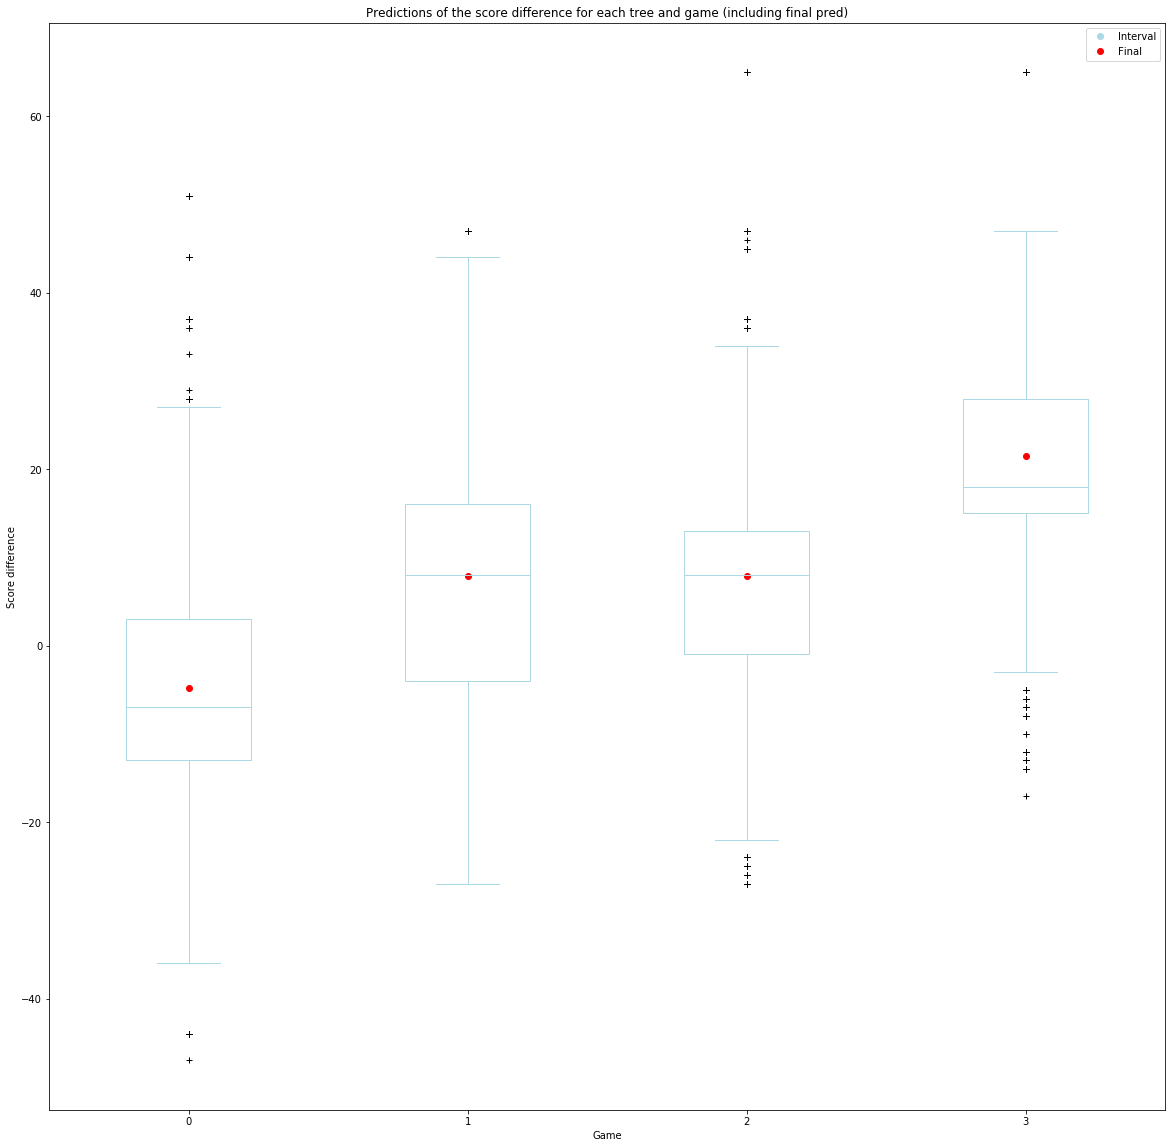

4it [00:00, 78.37it/s]
4it [00:00, 75.65it/s]

0    0.2896
1    0.6905
2    0.7468
3    0.9657
dtype: float64
Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')


[-4.71187373  7.68298565  7.87233982 21.0361146 ]


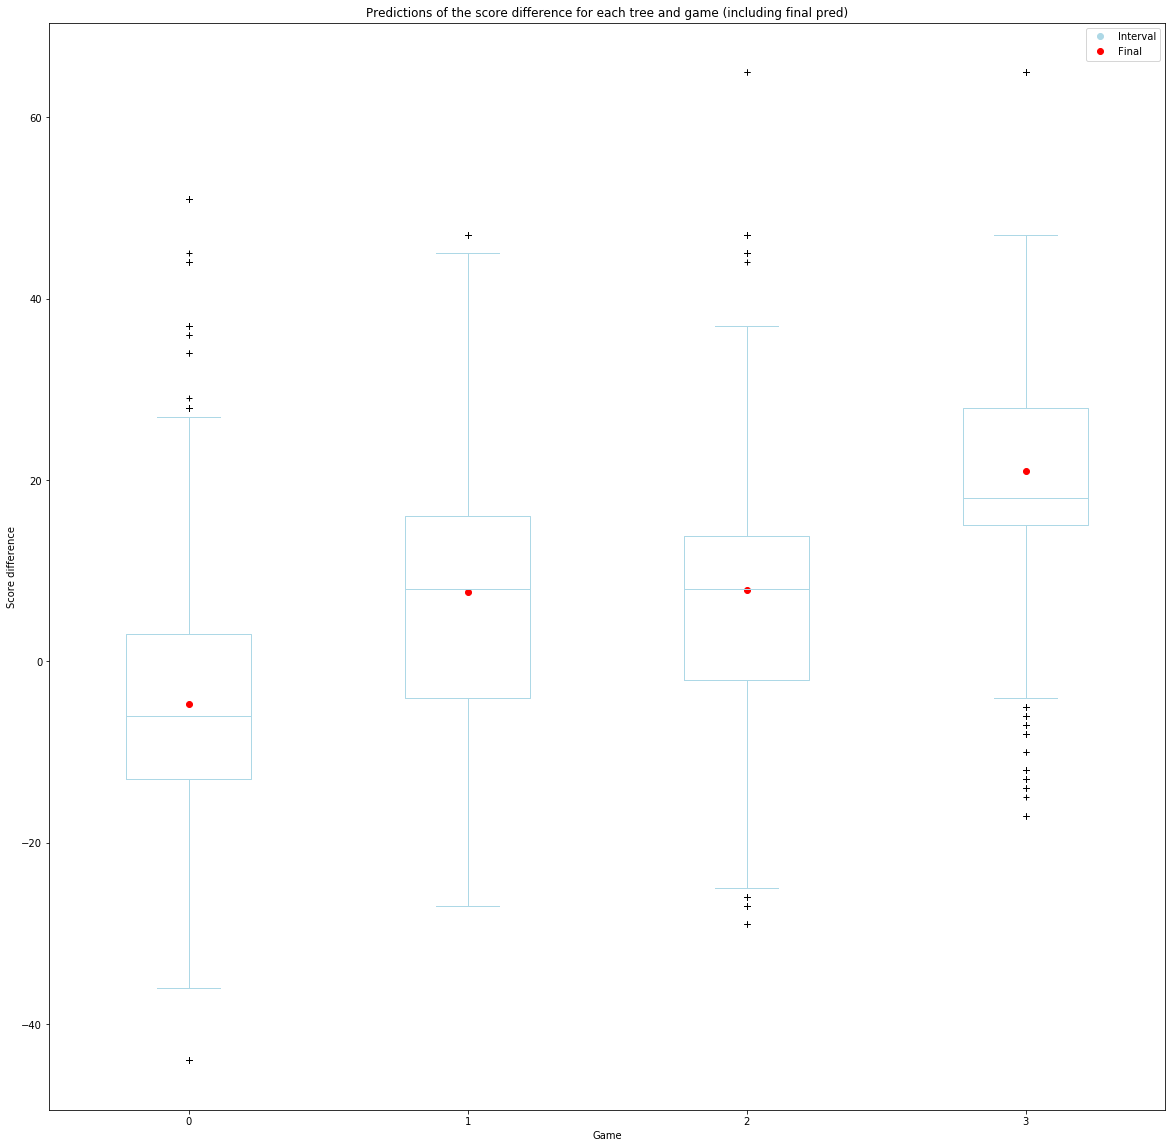

0    0.2952
1    0.6920
2    0.7380
3    0.9642
dtype: float64
(4, 20000)


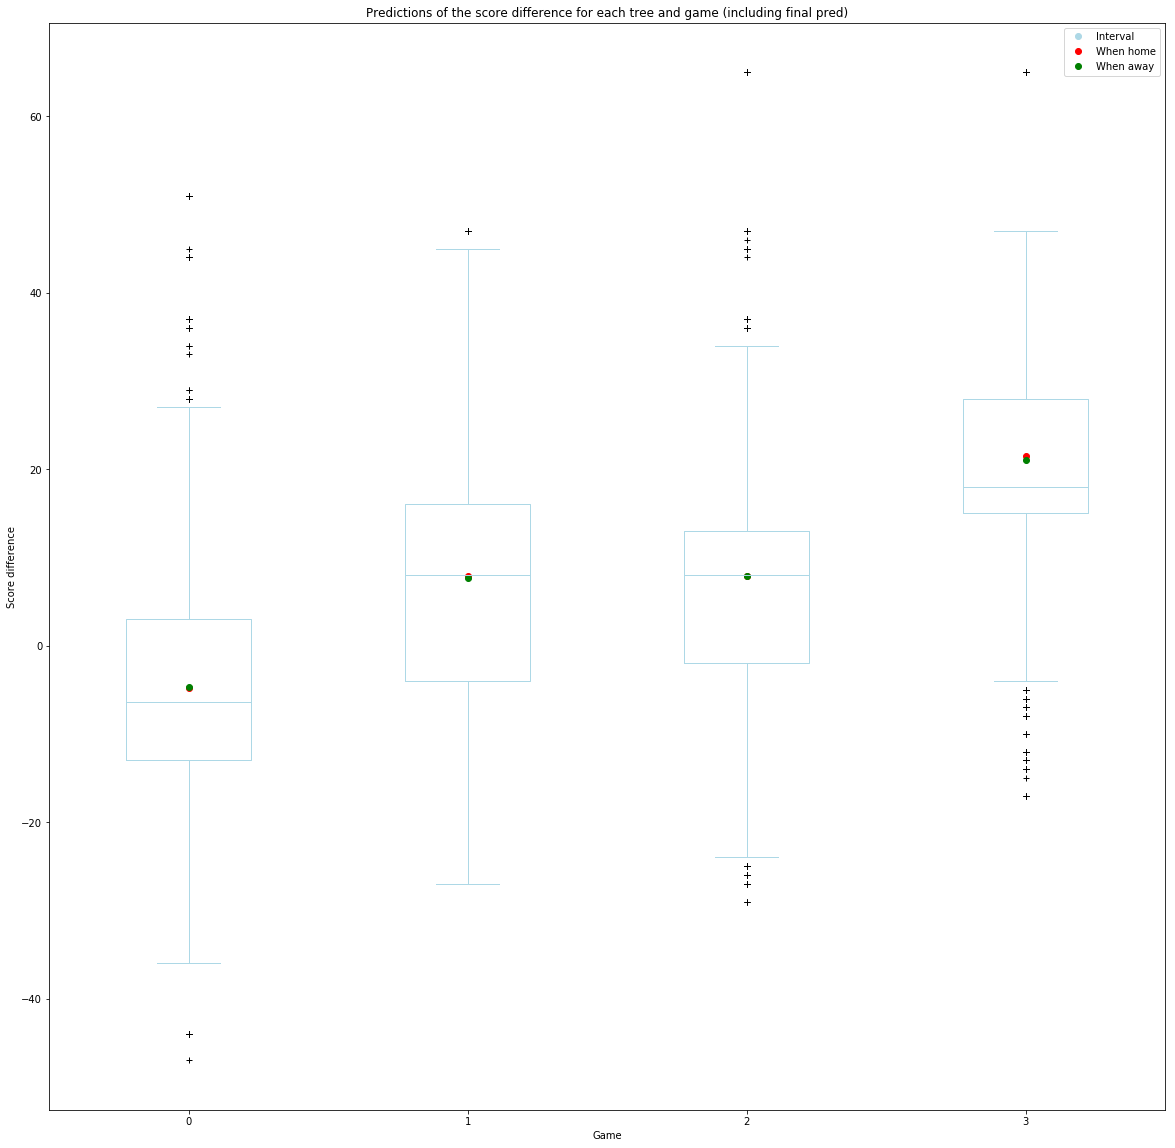

0    0.29240
1    0.69125
2    0.74240
3    0.96495
dtype: float64


In [15]:
#DB connection
db_connection = sql.connect(host='localhost', port=3306, database='acb', user='root', password='root')
df_aux = pd.read_sql('SELECT * FROM game where game.season >= {}'.format(from_year), con=db_connection)

# cols to keep for df_games
cols_to_keep = ['team_home_id', 'team_away_id', 'season', 'journey', 'kickoff_time',
                'score_home', 'score_away', 'referee_1']
cols_to_del = [c for c in df_aux.columns if c not in cols_to_keep]
df_aux.drop(cols_to_del, axis=1, inplace=True)

# generate the variables from historical games
df_predict = calculate_variables_last_X_predict(df_copa.copy(), df_aux, streak_days_long)
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_short)

# select the columns and predict
cols_to_use = X_train.columns
print(cols_to_use)
df_predict = df_predict[cols_to_use]
preds1 = model.predict(df_predict)
print(preds1)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = e.predict(df_predict)
df_preds_estimators1 = pd.DataFrame(data=preds_estimators)

# Plotting the intervals and the predicted value
axes = df_preds_estimators1.transpose().plot.box(figsize=(20, 20), positions=range(0,len(df_predict)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(preds1, color='red', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each tree and game (including final pred)")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' '),], ['Interval', 'Final'])
plt.show()

#print(df_preds_estimators)
prob1 = df_preds_estimators1.apply(lambda x: np.mean([1 if x[c]>0 else 0 for c in df_preds_estimators1.columns]), axis=1)
prob2 = df_preds_estimators1.apply(lambda x: np.mean([1 if x[c]<0 else 0 for c in df_preds_estimators1.columns]), axis=1)
print(prob1)



# changing home and away
df_predict = df_copa.copy()
df_predict["team_home_id"] = df_copa["team_away_id"]
df_predict["team_away_id"] = df_copa["team_home_id"]
# generate the variables from historical games
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_long)
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_short)

# select the columns and predict
cols_to_use = X_train.columns
print(cols_to_use)
df_predict = df_predict[cols_to_use]
preds2 = -model.predict(df_predict)
print(preds2)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = -e.predict(df_predict)
df_preds_estimators2 = pd.DataFrame(data=preds_estimators)

# Plotting the intervals and the predicted value
axes = df_preds_estimators2.transpose().plot.box(figsize=(20, 20), positions=range(0,len(df_predict)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(preds2, color='red', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each tree and game (including final pred)")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' '),], ['Interval', 'Final'])
plt.show()

prob1 = df_preds_estimators2.apply(lambda x: np.mean([1 if x[c]>0 else 0 for c in df_preds_estimators2.columns]), axis=1)
prob2 = df_preds_estimators2.apply(lambda x: np.mean([1 if x[c]<0 else 0 for c in df_preds_estimators2.columns]), axis=1)
print(prob1)



df_preds_estimators = df_preds_estimators1.merge(df_preds_estimators2, left_index = True, right_index= True)
print(df_preds_estimators.shape)

# Plotting the intervals and the predicted value
axes = df_preds_estimators.transpose().plot.box(figsize=(20, 20), positions=range(0,len(df_predict)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(preds1, color='red', marker='o', linestyle=' ')
axes.plot(preds2, color='green', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each tree and game (including final pred)")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' '),
             Line2D([0], [0], color='green', marker='o', linestyle=' ')], ['Interval', 'When home', 'When away'])
plt.show()

#print(df_preds_estimators)
prob1 = df_preds_estimators.apply(lambda x: np.mean([1 if x[c]>0 else 0 for c in df_preds_estimators.columns]), axis=1)
prob2 = df_preds_estimators.apply(lambda x: np.mean([1 if x[c]<0 else 0 for c in df_preds_estimators.columns]), axis=1)
print(prob1)

In [16]:
# Analyze the interval
preds_interval = df_preds_estimators.iloc[0]
inits_intervals=[1, 6, 16, 31]
inits_intervals =  [-i for i in inits_intervals[::-1]] + inits_intervals

prev = inits_intervals[0]
aux = [1 if sd <=(prev+0.001) else 0 for sd in preds_interval]
print("Prob of being in the interval Inf to {}: {}%".format(prev, np.mean(aux)*100))
#print("Estimated fair bet ratio for the interval Inf to {}: {}".format(prev, 1/np.mean(aux)))

for i in range(1, len(inits_intervals)):
    prev = inits_intervals[i-1] if inits_intervals[i-1]>0 else inits_intervals[i-1]+1
    end = inits_intervals[i]-1 if inits_intervals[i]>0 else inits_intervals[i]
    aux = [1 if sd >=(prev-0.001) and sd<(end+0.001) else 0 for sd in preds_interval]
    print("Prob of being in the interval {} to {}: {}%".format(prev, end, np.mean(aux)*100))
    #print("Estimated fair bet ratio for the interval {} to {}: {}".format(prev, end, 1/np.mean(aux)))

prev = inits_intervals[-1]
aux = [1 if sd >=(prev-0.001) else 0 for sd in preds_interval]
print("Prob of being in the interval {} to Inf: {}%".format(prev, np.mean(aux)*100))
#print("Estimated fair bet ratio for the interval {} to Inf: {}".format(prev, 1/np.mean(aux)))

Prob of being in the interval Inf to -31: 0.42%
Prob of being in the interval -30 to -16: 23.080000000000002%
Prob of being in the interval -15 to -6: 35.83%
Prob of being in the interval -5 to -1: 11.225%
Prob of being in the interval 0 to 0: 0.005%
Prob of being in the interval 1 to 5: 6.2%
Prob of being in the interval 6 to 15: 12.21%
Prob of being in the interval 16 to 30: 10.325%
Prob of being in the interval 31 to Inf: 0.475%


SEMIS

In [17]:
d = {'team_home_id': [3,6], 'team_away_id': [2,1], 'season': 2*[2018], 'kickoff_time' : 2*[pd.Timestamp(year=2019, month=2, day=12, hour=12)], 'journey' : 2*[21]}
df_copa = pd.DataFrame(data=d)
df_copa

,team_home_id,team_away_id,season,kickoff_time,journey
0,3,2,2018,2019-02-12 12:00:00,21
1,6,1,2018,2019-02-12 12:00:00,21


2it [00:00, 71.90it/s]
2it [00:00, 64.01it/s]


Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')
[-9.07379248  0.56007838]


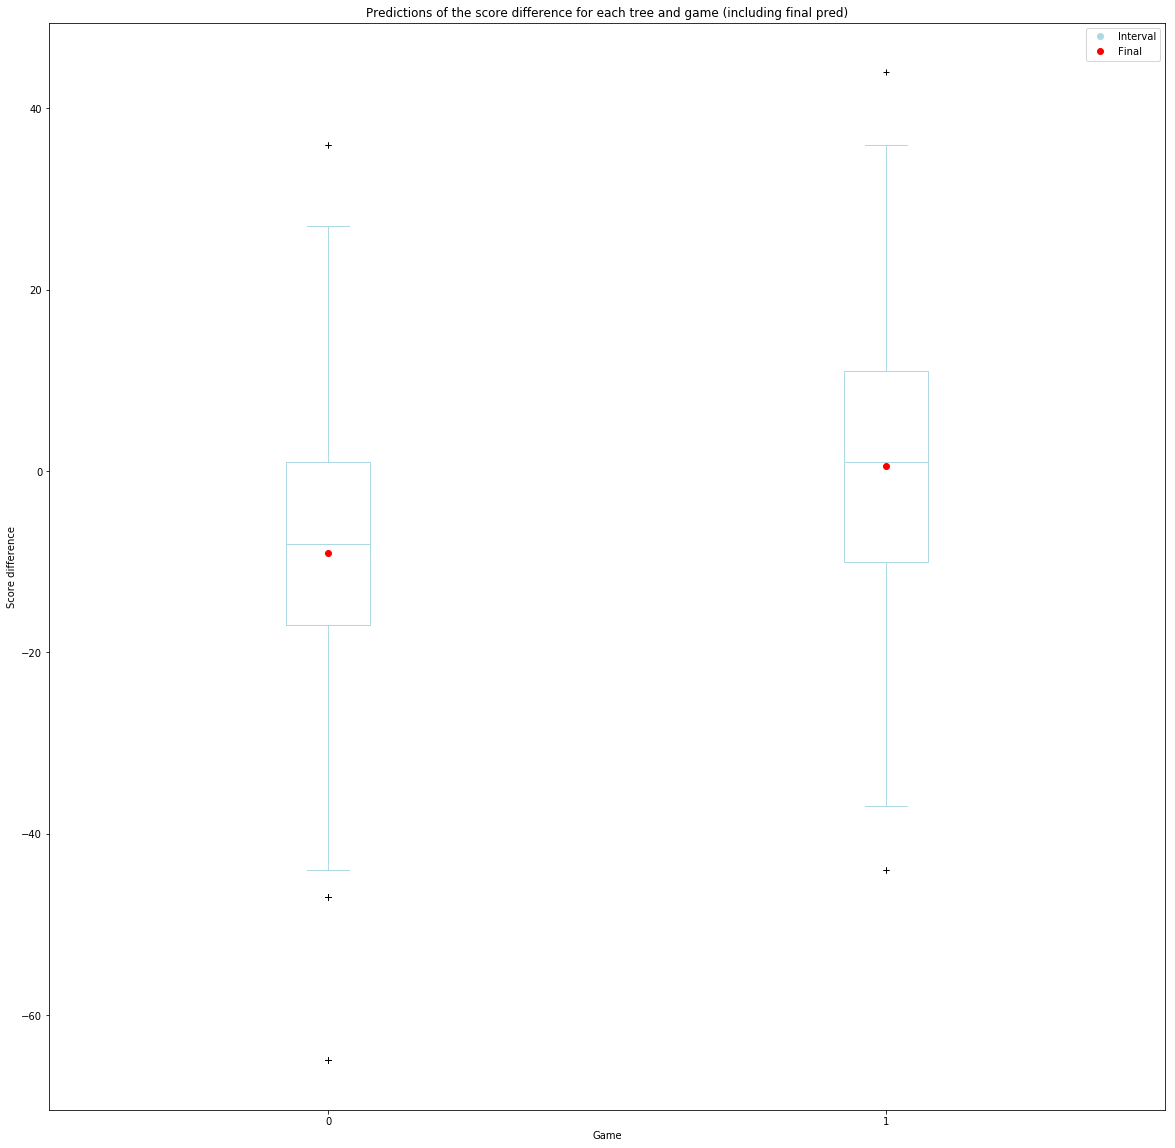

2it [00:00, 81.91it/s]
2it [00:00, 67.09it/s]

0    0.2812
1    0.5099
dtype: float64
Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')


[-9.0901715   0.53086399]


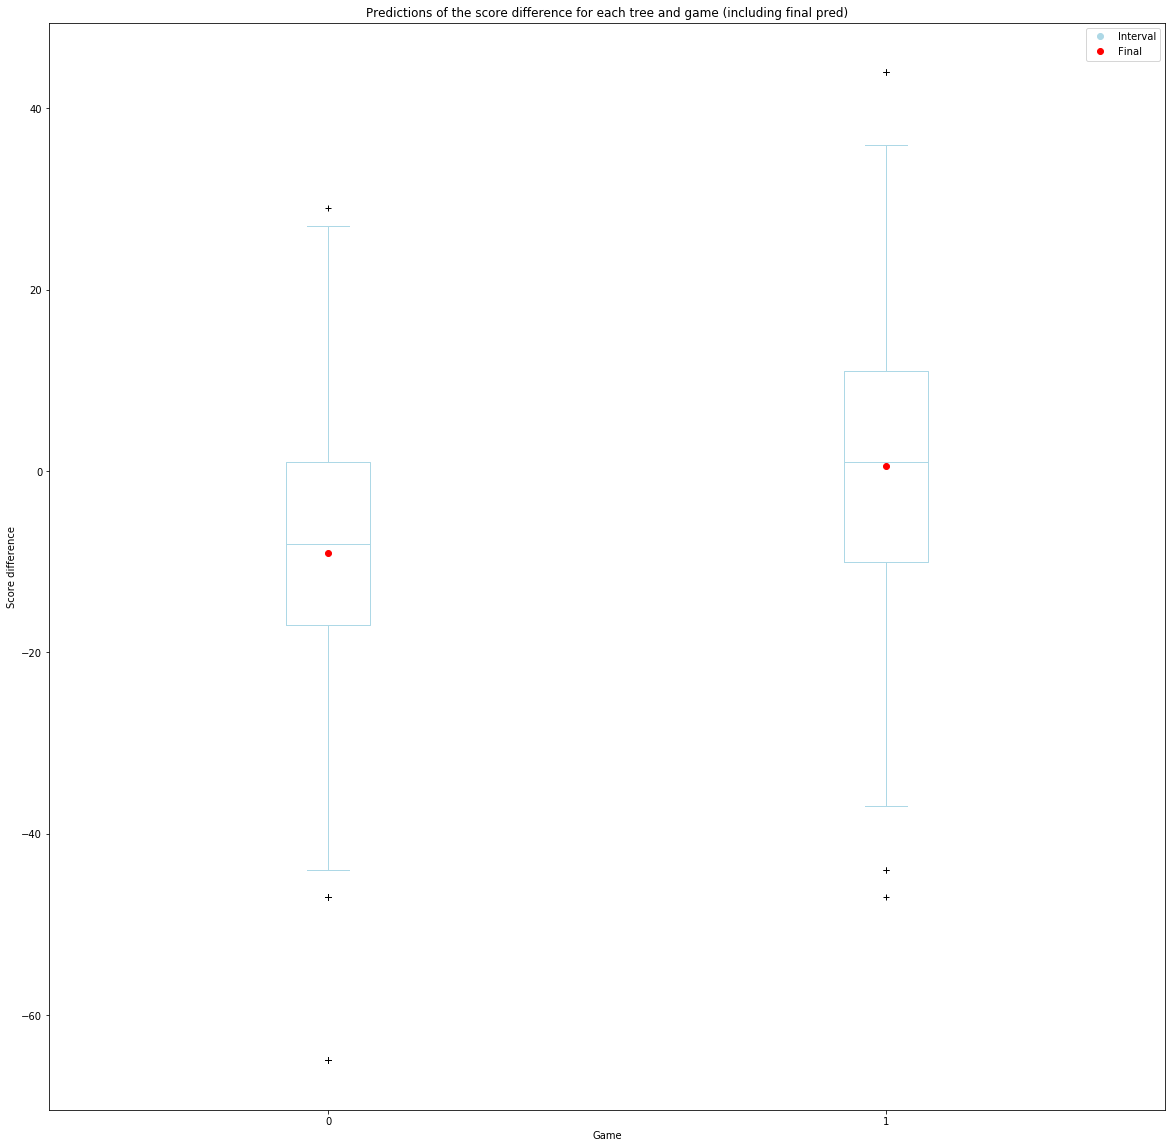

0    0.2733
1    0.5150
dtype: float64
(2, 20000)


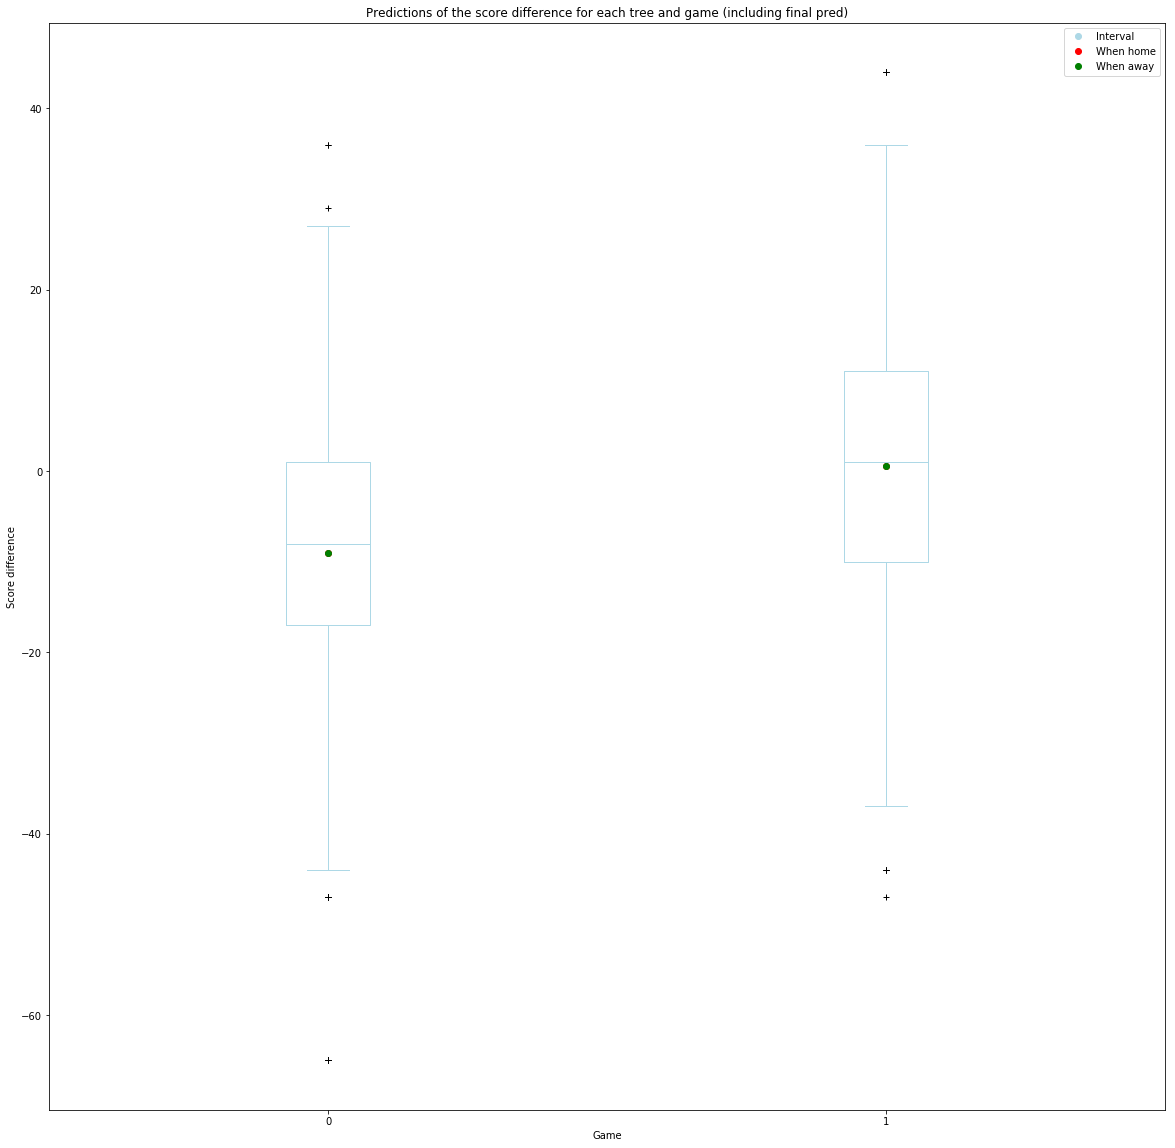

0    0.27725
1    0.51245
dtype: float64


In [18]:
#DB connection
db_connection = sql.connect(host='localhost', port=3306, database='acb', user='root', password='root')
df_aux = pd.read_sql('SELECT * FROM game where game.season >= {}'.format(from_year), con=db_connection)

# cols to keep for df_games
cols_to_keep = ['team_home_id', 'team_away_id', 'season', 'journey', 'kickoff_time',
                'score_home', 'score_away', 'referee_1']
cols_to_del = [c for c in df_aux.columns if c not in cols_to_keep]
df_aux.drop(cols_to_del, axis=1, inplace=True)

# generate the variables from historical games
df_predict = calculate_variables_last_X_predict(df_copa.copy(), df_aux, streak_days_long)
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_short)

# select the columns and predict
cols_to_use = X_train.columns
print(cols_to_use)
df_predict = df_predict[cols_to_use]
preds1 = model.predict(df_predict)
print(preds1)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = e.predict(df_predict)
df_preds_estimators1 = pd.DataFrame(data=preds_estimators)

# Plotting the intervals and the predicted value
axes = df_preds_estimators1.transpose().plot.box(figsize=(20, 20), positions=range(0,len(df_predict)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(preds1, color='red', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each tree and game (including final pred)")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' '),], ['Interval', 'Final'])
plt.show()

#print(df_preds_estimators)
prob1 = df_preds_estimators1.apply(lambda x: np.mean([1 if x[c]>0 else 0 for c in df_preds_estimators1.columns]), axis=1)
prob2 = df_preds_estimators1.apply(lambda x: np.mean([1 if x[c]<0 else 0 for c in df_preds_estimators1.columns]), axis=1)
print(prob1)



# changing home and away
df_predict = df_copa.copy()
df_predict["team_home_id"] = df_copa["team_away_id"]
df_predict["team_away_id"] = df_copa["team_home_id"]
# generate the variables from historical games
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_long)
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_short)

# select the columns and predict
cols_to_use = X_train.columns
print(cols_to_use)
df_predict = df_predict[cols_to_use]
preds2 = -model.predict(df_predict)
print(preds2)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = -e.predict(df_predict)
df_preds_estimators2 = pd.DataFrame(data=preds_estimators)

# Plotting the intervals and the predicted value
axes = df_preds_estimators2.transpose().plot.box(figsize=(20, 20), positions=range(0,len(df_predict)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(preds2, color='red', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each tree and game (including final pred)")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' '),], ['Interval', 'Final'])
plt.show()

prob1 = df_preds_estimators2.apply(lambda x: np.mean([1 if x[c]>0 else 0 for c in df_preds_estimators2.columns]), axis=1)
prob2 = df_preds_estimators2.apply(lambda x: np.mean([1 if x[c]<0 else 0 for c in df_preds_estimators2.columns]), axis=1)
print(prob1)



df_preds_estimators = df_preds_estimators1.merge(df_preds_estimators2, left_index = True, right_index= True)
print(df_preds_estimators.shape)

# Plotting the intervals and the predicted value
axes = df_preds_estimators.transpose().plot.box(figsize=(20, 20), positions=range(0,len(df_predict)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(preds1, color='red', marker='o', linestyle=' ')
axes.plot(preds2, color='green', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each tree and game (including final pred)")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' '),
             Line2D([0], [0], color='green', marker='o', linestyle=' ')], ['Interval', 'When home', 'When away'])
plt.show()

#print(df_preds_estimators)
prob1 = df_preds_estimators.apply(lambda x: np.mean([1 if x[c]>0 else 0 for c in df_preds_estimators.columns]), axis=1)
prob2 = df_preds_estimators.apply(lambda x: np.mean([1 if x[c]<0 else 0 for c in df_preds_estimators.columns]), axis=1)
print(prob1)

In [19]:
# Analyze the interva
preds_interval = df_preds_estimators.iloc[1]
inits_intervals=[1, 6, 16, 31]
inits_intervals =  [-i for i in inits_intervals[::-1]] + inits_intervals

prev = inits_intervals[0]
aux = [1 if sd <=(prev+0.001) else 0 for sd in preds_interval]
print("Prob of being in the interval Inf to {}: {}%".format(prev, np.mean(aux)*100))
#print("Estimated fair bet ratio for the interval Inf to {}: {}".format(prev, 1/np.mean(aux)))

for i in range(1, len(inits_intervals)):
    prev = inits_intervals[i-1] if inits_intervals[i-1]>0 else inits_intervals[i-1]+1
    end = inits_intervals[i]-1 if inits_intervals[i]>0 else inits_intervals[i]
    aux = [1 if sd >=(prev-0.001) and sd<(end+0.001) else 0 for sd in preds_interval]
    print("Prob of being in the interval {} to {}: {}%".format(prev, end, np.mean(aux)*100))
    #print("Estimated fair bet ratio for the interval {} to {}: {}".format(prev, end, 1/np.mean(aux)))

prev = inits_intervals[-1]
aux = [1 if sd >=(prev-0.001) else 0 for sd in preds_interval]
print("Prob of being in the interval {} to Inf: {}%".format(prev, np.mean(aux)*100))
#print("Estimated fair bet ratio for the interval {} to Inf: {}".format(prev, 1/np.mean(aux)))

Prob of being in the interval Inf to -31: 0.155%
Prob of being in the interval -30 to -16: 13.995%
Prob of being in the interval -15 to -6: 18.715%
Prob of being in the interval -5 to -1: 15.834999999999999%
Prob of being in the interval 0 to 0: 0.005%
Prob of being in the interval 1 to 5: 13.719999999999999%
Prob of being in the interval 6 to 15: 19.009999999999998%
Prob of being in the interval 16 to 30: 18.365000000000002%
Prob of being in the interval 31 to Inf: 0.095%


FINAL

In [20]:
d = {'team_home_id': [2,2], 'team_away_id': [1,6], 'season': 2*[2018], 'kickoff_time' : 2*[pd.Timestamp(year=2019, month=2, day=12, hour=12)], 'journey' : 2*[21]}
df_copa = pd.DataFrame(data=d)
df_copa

,team_home_id,team_away_id,season,kickoff_time,journey
0,2,1,2018,2019-02-12 12:00:00,21
1,2,6,2018,2019-02-12 12:00:00,21


2it [00:00, 63.84it/s]
2it [00:00, 58.14it/s]


Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')
[-0.8893827  -3.26799177]


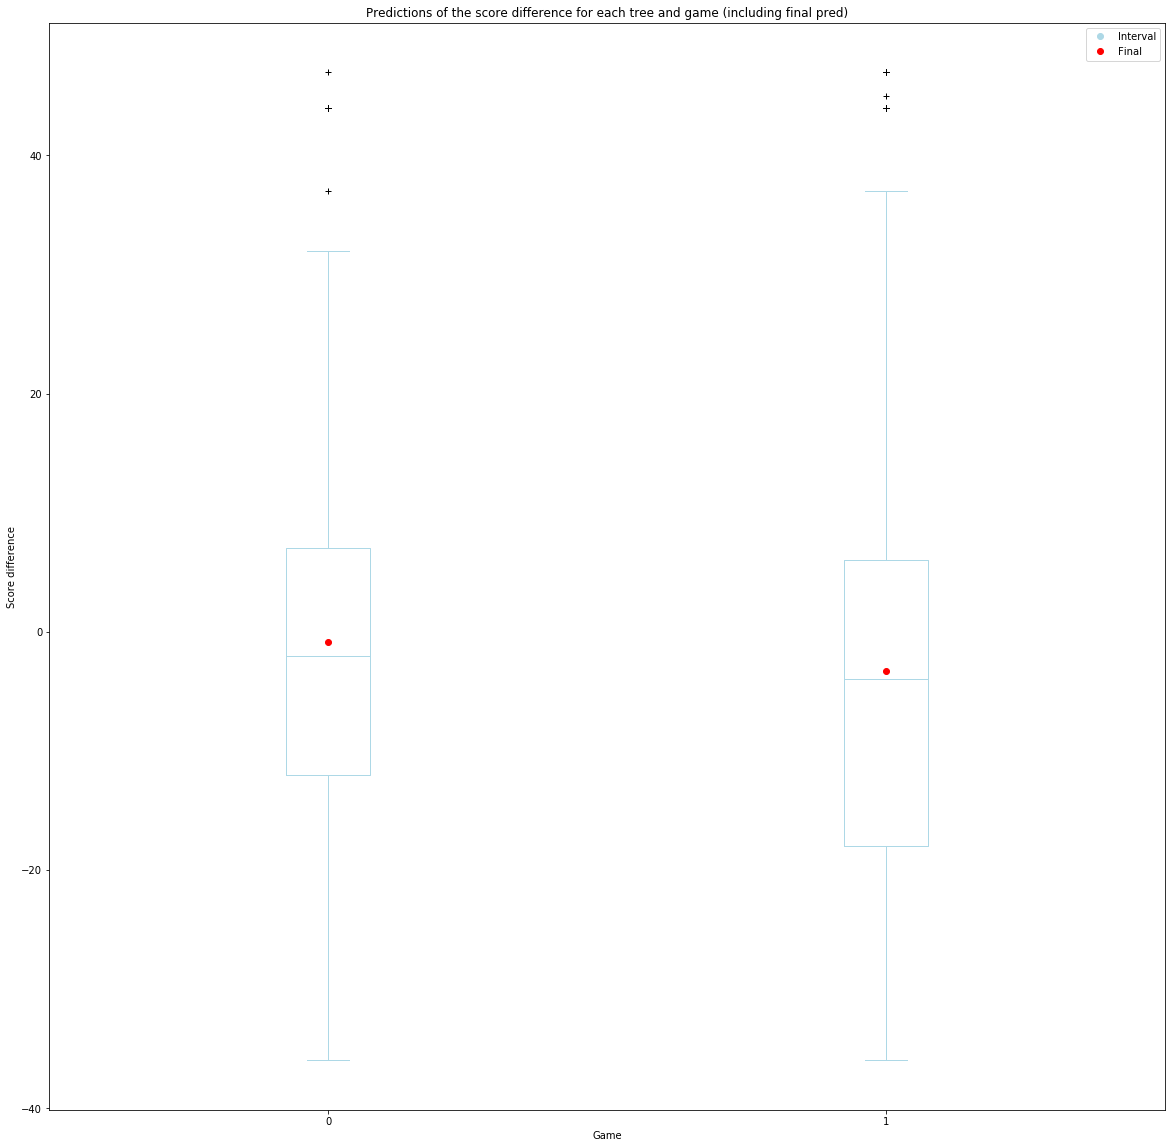

2it [00:00, 72.64it/s]
2it [00:00, 51.65it/s]

0    0.4722
1    0.4035
dtype: float64
Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')


[-1.12105318 -3.21255788]


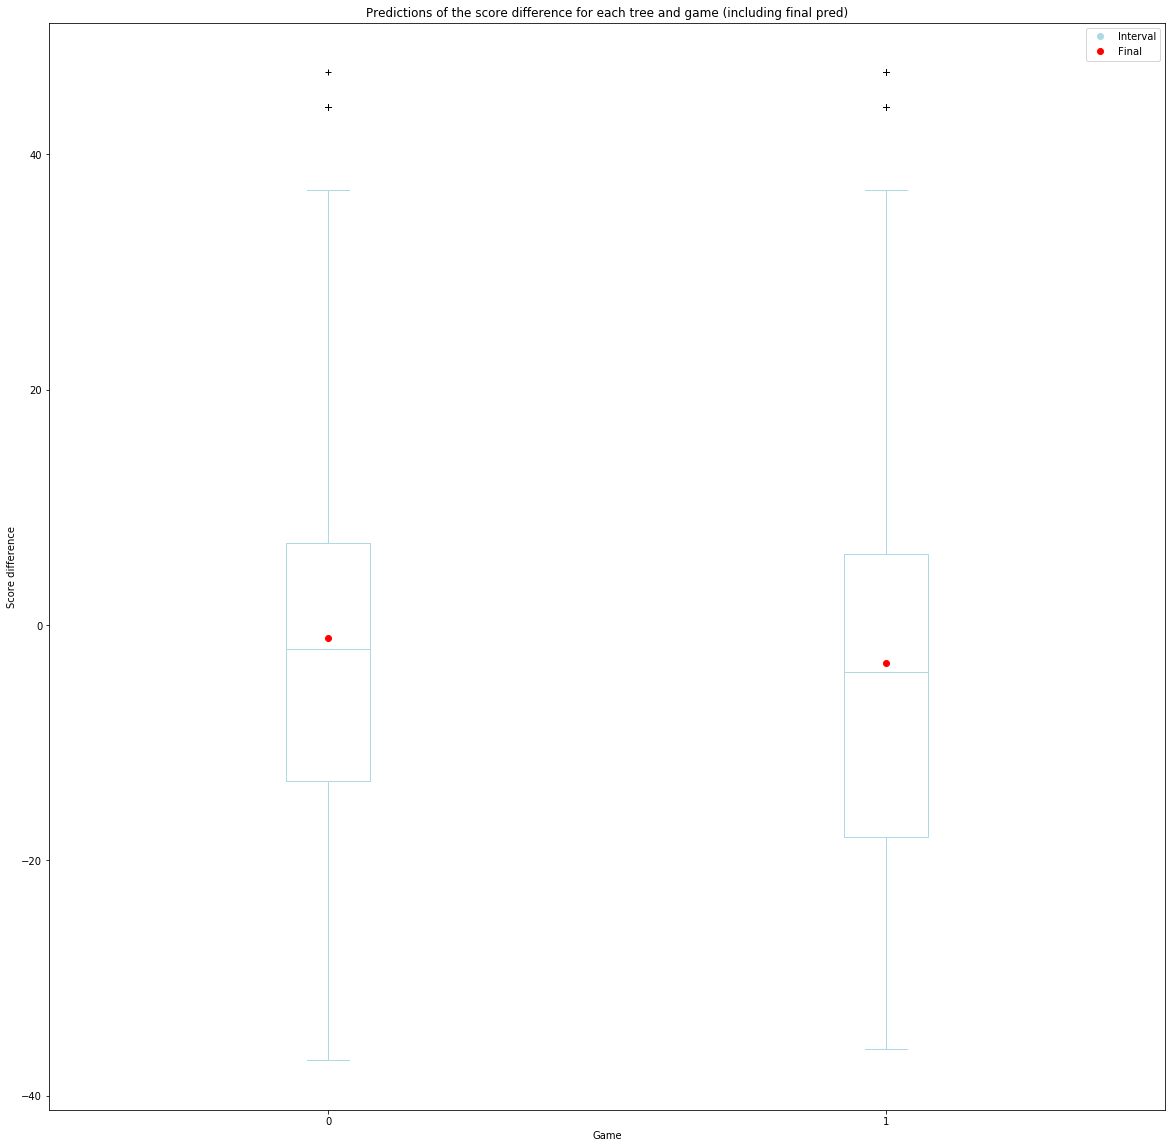

0    0.4649
1    0.4014
dtype: float64
(2, 20000)


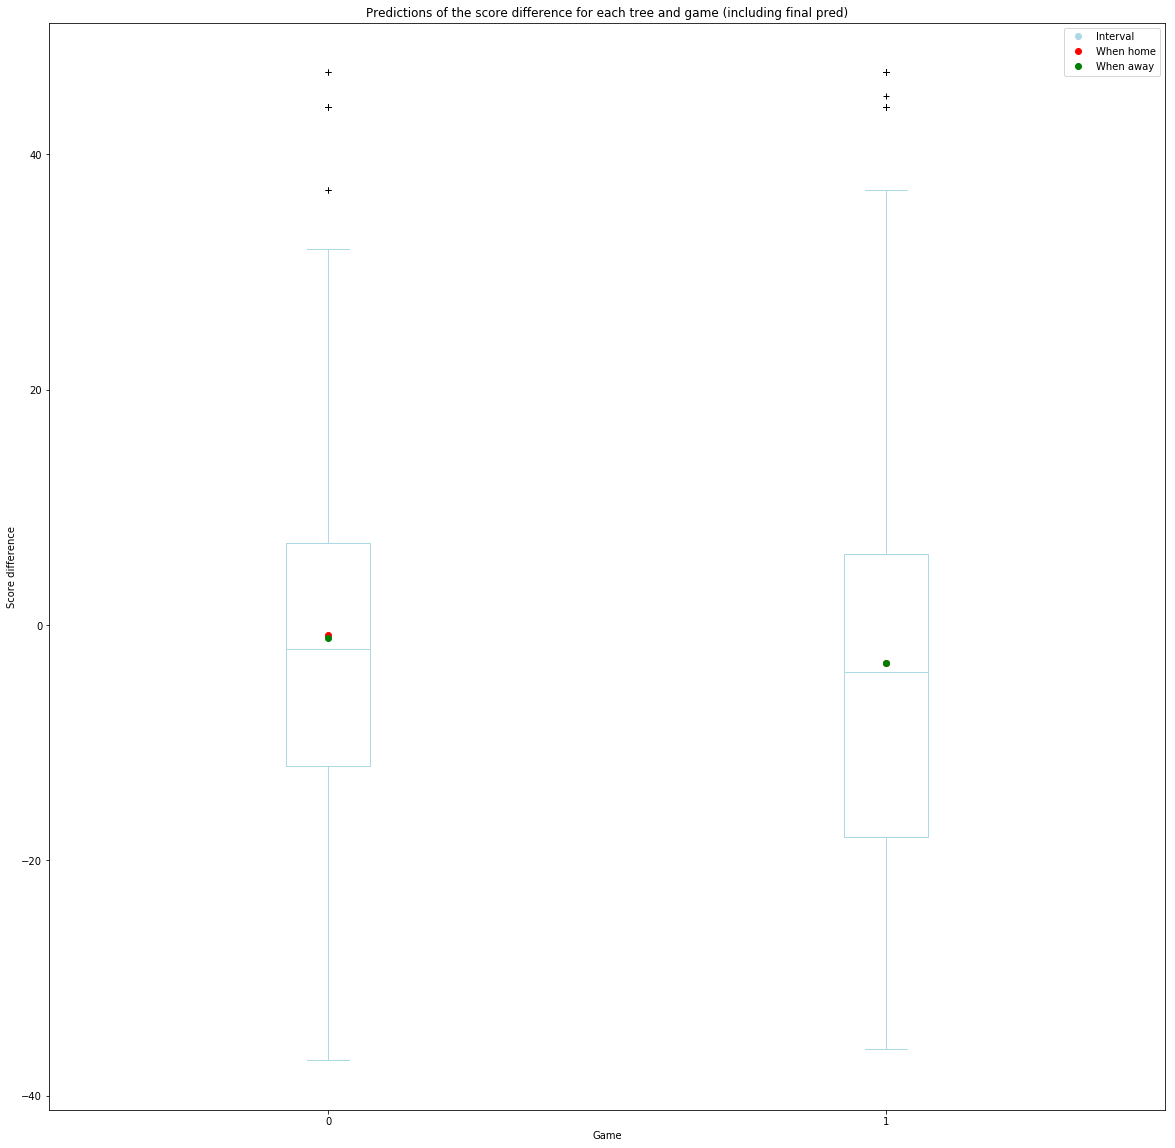

0    0.46855
1    0.40245
dtype: float64


In [21]:
#DB connection
db_connection = sql.connect(host='localhost', port=3306, database='acb', user='root', password='root')
df_aux = pd.read_sql('SELECT * FROM game where game.season >= {}'.format(from_year), con=db_connection)

# cols to keep for df_games
cols_to_keep = ['team_home_id', 'team_away_id', 'season', 'journey', 'kickoff_time',
                'score_home', 'score_away', 'referee_1']
cols_to_del = [c for c in df_aux.columns if c not in cols_to_keep]
df_aux.drop(cols_to_del, axis=1, inplace=True)

# generate the variables from historical games
df_predict = calculate_variables_last_X_predict(df_copa.copy(), df_aux, streak_days_long)
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_short)

# select the columns and predict
cols_to_use = X_train.columns
print(cols_to_use)
df_predict = df_predict[cols_to_use]
preds1 = model.predict(df_predict)
print(preds1)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = e.predict(df_predict)
df_preds_estimators1 = pd.DataFrame(data=preds_estimators)

# Plotting the intervals and the predicted value
axes = df_preds_estimators1.transpose().plot.box(figsize=(20, 20), positions=range(0,len(df_predict)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(preds1, color='red', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each tree and game (including final pred)")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' '),], ['Interval', 'Final'])
plt.show()

#print(df_preds_estimators)
prob1 = df_preds_estimators1.apply(lambda x: np.mean([1 if x[c]>0 else 0 for c in df_preds_estimators1.columns]), axis=1)
prob2 = df_preds_estimators1.apply(lambda x: np.mean([1 if x[c]<0 else 0 for c in df_preds_estimators1.columns]), axis=1)
print(prob1)



# changing home and away
df_predict = df_copa.copy()
df_predict["team_home_id"] = df_copa["team_away_id"]
df_predict["team_away_id"] = df_copa["team_home_id"]
# generate the variables from historical games
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_long)
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_short)

# select the columns and predict
cols_to_use = X_train.columns
print(cols_to_use)
df_predict = df_predict[cols_to_use]
preds2 = -model.predict(df_predict)
print(preds2)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = -e.predict(df_predict)
df_preds_estimators2 = pd.DataFrame(data=preds_estimators)

# Plotting the intervals and the predicted value
axes = df_preds_estimators2.transpose().plot.box(figsize=(20, 20), positions=range(0,len(df_predict)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(preds2, color='red', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each tree and game (including final pred)")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' '),], ['Interval', 'Final'])
plt.show()

prob1 = df_preds_estimators2.apply(lambda x: np.mean([1 if x[c]>0 else 0 for c in df_preds_estimators2.columns]), axis=1)
prob2 = df_preds_estimators2.apply(lambda x: np.mean([1 if x[c]<0 else 0 for c in df_preds_estimators2.columns]), axis=1)
print(prob1)



df_preds_estimators = df_preds_estimators1.merge(df_preds_estimators2, left_index = True, right_index= True)
print(df_preds_estimators.shape)

# Plotting the intervals and the predicted value
axes = df_preds_estimators.transpose().plot.box(figsize=(20, 20), positions=range(0,len(df_predict)), showfliers=True,
                                                flierprops=dict(marker='+', color='lightblue'),
                                                color={'whiskers': 'lightblue', 'caps': 'lightblue',
                                                       'medians': 'lightblue', 'boxes': 'lightblue'})
axes.plot(preds1, color='red', marker='o', linestyle=' ')
axes.plot(preds2, color='green', marker='o', linestyle=' ')
axes.set_title("Predictions of the score difference for each tree and game (including final pred)")
axes.set_xlabel("Game")
axes.set_ylabel("Score difference")
axes.legend([Line2D([0], [0], color='lightblue', marker='o', linestyle=' '),
             Line2D([0], [0], color='red', marker='o', linestyle=' '),
             Line2D([0], [0], color='green', marker='o', linestyle=' ')], ['Interval', 'When home', 'When away'])
plt.show()

#print(df_preds_estimators)
prob1 = df_preds_estimators.apply(lambda x: np.mean([1 if x[c]>0 else 0 for c in df_preds_estimators.columns]), axis=1)
prob2 = df_preds_estimators.apply(lambda x: np.mean([1 if x[c]<0 else 0 for c in df_preds_estimators.columns]), axis=1)
print(prob1)

In [22]:
# Analyze the interva
preds_interval = df_preds_estimators.iloc[1]
inits_intervals=[1, 6, 16, 31]
inits_intervals =  [-i for i in inits_intervals[::-1]] + inits_intervals

prev = inits_intervals[0]
aux = [1 if sd <=(prev+0.001) else 0 for sd in preds_interval]
print("Prob of being in the interval Inf to {}: {}%".format(prev, np.mean(aux)*100))
#print("Estimated fair bet ratio for the interval Inf to {}: {}".format(prev, 1/np.mean(aux)))

for i in range(1, len(inits_intervals)):
    prev = inits_intervals[i-1] if inits_intervals[i-1]>0 else inits_intervals[i-1]+1
    end = inits_intervals[i]-1 if inits_intervals[i]>0 else inits_intervals[i]
    aux = [1 if sd >=(prev-0.001) and sd<(end+0.001) else 0 for sd in preds_interval]
    print("Prob of being in the interval {} to {}: {}%".format(prev, end, np.mean(aux)*100))
    #print("Estimated fair bet ratio for the interval {} to {}: {}".format(prev, end, 1/np.mean(aux)))

prev = inits_intervals[-1]
aux = [1 if sd >=(prev-0.001) else 0 for sd in preds_interval]
print("Prob of being in the interval {} to Inf: {}%".format(prev, np.mean(aux)*100))
#print("Estimated fair bet ratio for the interval {} to Inf: {}".format(prev, 1/np.mean(aux)))

Prob of being in the interval Inf to -31: 0.09%
Prob of being in the interval -30 to -16: 29.18%
Prob of being in the interval -15 to -6: 16.525000000000002%
Prob of being in the interval -5 to -1: 13.900000000000002%
Prob of being in the interval 0 to 0: 0.005%
Prob of being in the interval 1 to 5: 14.249999999999998%
Prob of being in the interval 6 to 15: 16.1%
Prob of being in the interval 16 to 30: 8.765%
Prob of being in the interval 31 to Inf: 1.06%


WINNER

In [23]:
d = {'team_home_id': [9, 9, 9, 9, 9, 9, 9,3,3,3,3,3,3,2,2,2,2,2,18,18,18,18,6,6,6,10,10,1], 'team_away_id': [3,2,18,6,10,1,7,2,18,6,10,1,7,18,6,10,1,7,6,10,1,7,10,1,7,1,7,7], 'season': 28*[2018], 'kickoff_time' : 28*[pd.Timestamp(year=2019, month=2, day=12, hour=12)], 'journey' : 28*[21]}
df_copa = pd.DataFrame(data=d)
df_copa

,team_home_id,team_away_id,season,kickoff_time,journey
0,9,3,2018,2019-02-12 12:00:00,21
1,9,2,2018,2019-02-12 12:00:00,21
2,9,18,2018,2019-02-12 12:00:00,21
3,9,6,2018,2019-02-12 12:00:00,21
4,9,10,2018,2019-02-12 12:00:00,21
5,9,1,2018,2019-02-12 12:00:00,21
6,9,7,2018,2019-02-12 12:00:00,21
7,3,2,2018,2019-02-12 12:00:00,21
8,3,18,2018,2019-02-12 12:00:00,21
9,3,6,2018,2019-02-12 12:00:00,21


In [24]:
#DB connection
db_connection = sql.connect(host='localhost', port=3306, database='acb', user='root', password='root')
df_aux = pd.read_sql('SELECT * FROM game where game.season >= {}'.format(from_year), con=db_connection)

# cols to keep for df_games
cols_to_keep = ['team_home_id', 'team_away_id', 'season', 'journey', 'kickoff_time',
                'score_home', 'score_away', 'referee_1']
cols_to_del = [c for c in df_aux.columns if c not in cols_to_keep]
df_aux.drop(cols_to_del, axis=1, inplace=True)

# generate the variables from historical games
df_predict = calculate_variables_last_X_predict(df_copa.copy(), df_aux, streak_days_long)
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_short)

# select the columns and predict
cols_to_use = X_train.columns
print(cols_to_use)
df_predict = df_predict[cols_to_use]
preds1 = model.predict(df_predict)
print(preds1)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = e.predict(df_predict)
df_preds_estimators1 = pd.DataFrame(data=preds_estimators)


# changing home and away
df_predict = df_copa.copy()
df_predict["team_home_id"] = df_copa["team_away_id"]
df_predict["team_away_id"] = df_copa["team_home_id"]
# generate the variables from historical games
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_long)
df_predict = calculate_variables_last_X_predict(df_predict, df_aux, streak_days_short)

# select the columns and predict
cols_to_use = X_train.columns
print(cols_to_use)
df_predict = df_predict[cols_to_use]
preds2 = -model.predict(df_predict)
print(preds2)

# Estimating an interval
preds_estimators = {}
for i in range(len(model.estimators_)):
    e = model.estimators_[i]
    preds_estimators["Est" + str(i).zfill(2)] = -e.predict(df_predict)
df_preds_estimators2 = pd.DataFrame(data=preds_estimators)


df_preds_estimators = df_preds_estimators1.merge(df_preds_estimators2, left_index = True, right_index= True)
print(df_preds_estimators.shape)


#print(df_preds_estimators)
df_copa["prob1"] = df_preds_estimators.apply(lambda x: np.mean([1 if x[c]>0 else 0 for c in df_preds_estimators.columns]), axis=1)
df_copa["prob2"] = df_preds_estimators.apply(lambda x: np.mean([1 if x[c]<0 else 0 for c in df_preds_estimators.columns]), axis=1)
print(prob1)
df_copa

28it [00:00, 74.60it/s]
28it [00:00, 70.74it/s]


Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')
[ -4.82040986 -10.5696948   -1.63979169  -6.67335725  -5.84347424
 -10.57587291   5.2287127   -9.07379248   1.80293757  -2.71189879
  -0.16488385  -6.83968365   5.26404827   7.84203027  -3.26799177
  12.61906816  -0.8893827   19.38288562   2.3323208   -1.71865905
  -3.32415081   7.87509066   7.87832137   0.56007838  17.72680738
 -11.77433682   2.74560821  21.51497773]


28it [00:00, 70.81it/s]
28it [00:00, 91.11it/s]


Index(['team_home_id', 'team_away_id', 'win_rate_home_last100',
       'score_diff_avg_home_last100', 'win_rate_away_last100',
       'score_diff_avg_away_last100', 'win_rate_home_last20',
       'score_diff_avg_home_last20', 'win_rate_away_last20',
       'score_diff_avg_away_last20'],
      dtype='object')
[ -4.71187373 -10.99855577  -1.72143283  -7.04368839  -5.87377955
 -10.84797746   4.89822433  -9.0901715    2.13081013  -2.68599549
   0.03719829  -7.24163984   5.28575359   7.68298565  -3.21255788
  12.59662565  -1.12105318  19.31374462   2.04647164  -1.85629868
  -3.6171503    7.64310743   7.87233982   0.53086399  17.80239145
 -11.88866788   2.6272439   21.0361146 ]
(28, 20000)
0    0.46855
1    0.40245
dtype: float64


,team_home_id,team_away_id,season,kickoff_time,journey,prob1,prob2
0,9,3,2018,2019-02-12 12:00:00,21,0.29240,0.70755
1,9,2,2018,2019-02-12 12:00:00,21,0.24240,0.75760
2,9,18,2018,2019-02-12 12:00:00,21,0.47635,0.52360
3,9,6,2018,2019-02-12 12:00:00,21,0.27740,0.72260
4,9,10,2018,2019-02-12 12:00:00,21,0.31775,0.68185
5,9,1,2018,2019-02-12 12:00:00,21,0.18640,0.81360
6,9,7,2018,2019-02-12 12:00:00,21,0.64140,0.35855
7,3,2,2018,2019-02-12 12:00:00,21,0.27725,0.72275
8,3,18,2018,2019-02-12 12:00:00,21,0.62585,0.37410
9,3,6,2018,2019-02-12 12:00:00,21,0.45020,0.54980


In [25]:
prob_IBT=df_copa['prob1'][0]*(df_copa['prob1'][13]*df_copa['prob1'][1]+df_copa['prob2'][13]*df_copa['prob1'][2])
prob_IBT

0.091998415075

In [26]:
prob_UNI=df_copa['prob2'][0]*(df_copa['prob1'][13]*df_copa['prob1'][7]+df_copa['prob2'][13]*df_copa['prob1'][8])
prob_UNI

0.2723220208875

In [27]:
prob_BAR=df_copa['prob1'][13]*(df_copa['prob1'][0]*df_copa['prob2'][1]+df_copa['prob2'][0]*df_copa['prob2'][7])
prob_BAR

0.506619891728125

In [28]:
prob_VAL=df_copa['prob2'][13]*(df_copa['prob1'][0]*df_copa['prob2'][2]+df_copa['prob2'][0]*df_copa['prob2'][8])
prob_VAL

0.12899423558125

In [29]:
suma_lado_izq=prob_IBT+prob_UNI+prob_BAR+prob_VAL
suma_lado_izq

0.9999345632718751

In [30]:
prob_BAS=df_copa['prob1'][22]*(df_copa['prob1'][27]*df_copa['prob1'][23]+df_copa['prob2'][27]*df_copa['prob1'][24])
prob_BAS

0.3914693295999999

In [31]:
prob_JOV=df_copa['prob2'][22]*(df_copa['prob1'][27]*df_copa['prob1'][25]+df_copa['prob2'][27]*df_copa['prob1'][26])
prob_JOV

0.0474506983665

In [32]:
prob_MAD=df_copa['prob1'][27]*(df_copa['prob1'][22]*df_copa['prob2'][23]+df_copa['prob2'][22]*df_copa['prob2'][25])
prob_MAD

0.5549290523595

In [33]:
prob_EST=df_copa['prob2'][27]*(df_copa['prob1'][22]*df_copa['prob2'][24]+df_copa['prob2'][22]*df_copa['prob2'][26])
prob_EST

0.005901328543

In [34]:
suma_lado_der=prob_BAS+prob_JOV+prob_MAD+prob_EST
suma_lado_der

0.9997504088689998

In [35]:
win_IBT=prob_IBT*(prob_BAS*df_copa['prob1'][3]+prob_JOV*df_copa['prob1'][4]+prob_MAD*df_copa['prob1'][5]+prob_EST*df_copa['prob1'][6])
win_IBT

0.02124196842987327

In [36]:
win_UNI=prob_UNI*(prob_BAS*df_copa['prob1'][9]+prob_JOV*df_copa['prob1'][10]+prob_MAD*df_copa['prob1'][11]+prob_EST*df_copa['prob1'][12])
win_UNI

0.10610459778377329

In [37]:
win_BAR=prob_BAR*(prob_BAS*df_copa['prob1'][14]+prob_JOV*df_copa['prob1'][15]+prob_MAD*df_copa['prob1'][16]+prob_EST*df_copa['prob1'][17])
win_BAR

0.23292557318308443

In [38]:
win_VAL=prob_VAL*(prob_BAS*df_copa['prob1'][18]+prob_JOV*df_copa['prob1'][19]+prob_MAD*df_copa['prob1'][20]+prob_EST*df_copa['prob1'][21])
win_VAL

0.06218930328733224

In [39]:
win_BAS=prob_BAS*(prob_IBT*df_copa['prob2'][3]+prob_UNI*df_copa['prob2'][9]+prob_BAR*df_copa['prob2'][14]+prob_VAL*df_copa['prob2'][18])
win_BAS

0.22380688245491812

In [40]:
win_JOV=prob_JOV*(prob_IBT*df_copa['prob2'][4]+prob_UNI*df_copa['prob2'][10]+prob_BAR*df_copa['prob2'][15]+prob_VAL*df_copa['prob2'][19])
win_JOV

0.018007549599955285

In [41]:
win_MAD=prob_MAD*(prob_IBT*df_copa['prob2'][5]+prob_UNI*df_copa['prob2'][11]+prob_BAR*df_copa['prob2'][16]+prob_VAL*df_copa['prob2'][20])
win_MAD

0.33429697383396606

In [42]:
win_EST=prob_EST*(prob_IBT*df_copa['prob2'][6]+prob_UNI*df_copa['prob2'][12]+prob_BAR*df_copa['prob2'][17]+prob_VAL*df_copa['prob2'][21])
win_EST

0.0010874284708798517

In [43]:
sum_WIN=win_EST+win_MAD+win_JOV+win_BAS+win_VAL+win_BAR+win_UNI+win_IBT
sum_WIN

0.9996602770437826